# Exercise 1: Image Compression

You are organizing a tic-tac-toe championship with your friends, where all the games will be played on a gaming console, i.e. on a digital board. Due to the wide interest in the championship, you want to share the live games on internet. Thus, you plan to record the games using an external camera, and transmit it. Your friend from mechanical engineering has already agreed to help you with the camera setup. Unfortunately, being a poor student, you can only afford a cheap camera which provides you noisy images. To make the matter worse, your internet connection is poor and hence you cannot transmit the full images directly due to large file size. Thankfully, you are currently taking a computer vision course :) Thus you decide to use your newly acquired knowledge to design a software which can i) compress the images obtained from the camera for efficient transmission, and ii) reconstruct the compressed images on the client side to generate a high quality, noise free, output. An overview of the entire pipeline is shown in Figure.

![](https://drive.google.com/uc?export=view&id=1GSONZLYDWt0OxmbzdVNIXR8evSSTODco)

**Details about the setup**
* The camera is placed exactly about the console screen. Both the console, and the camera are rigidly placed, i.e. they do not move. Furthermore, the screen is always fully visible in the camera and we do not have any other object, e.g. hand entering the camera view.
* The actual game image $x$ (the one displayed on the console screen) is a discrete RGB image of size 96 x 96. Each pixel in the image is an integer which can take values between [0, 255]. In fact, the pixels at each location in the image can take only one of 4 values, white for the background region, black for the grid lines, red for the X sign, and green for the O sign.
* The camera provides you an RGB image $\hat{x}$ of size 96 x 96 which is corrupted by noise. Each pixel in the image is a 32-bit floating-point number which can take any continuous value between [0.0, 255.0].  Note that due to the presence of noise, the pixels in the camera image can take any continuous value, even though pixels in the original image only have discrete integral values.


In order to design your compression algorithm, you have access to a dataset $\mathcal{D}_{train} = \{\hat{x}_i\}_{i=1}^{100}$ containing 100 noisy images captured using the exact same camera setup. You can use this dataset to learn codebook $\mathcal{C}$ which you use for compression. For instance, if you use Principal Component Analysis (PCA) approach for compression, the codebook $\mathcal{C}$ will contain the first $K$ principal components, as well as the mean image. Given a new image $\hat{x}_j$ from a game, and the learnt codebook $\mathcal{C}$, your compression algorithm should output a compressed representation $z_j = \texttt{Compress}(\hat{x}_j, \mathcal{C})$, which is smaller in size compared to $\hat{x}_j$. Finally, you should also provide a reconstruction algorithm which can recover an estimate $x^{pred}_j = \texttt{Reconstruct}(z_j, \mathcal{C})$ of the **original** clean image $x_j$ given the compressed version $z_j$ and the codebook $\mathcal{C}$.

For debugging purposes, we also provde a validation dataset containing 50 noisy images, as well as the clean ground truth for each of these images.

**Evaluation Criteria**

For evaluation, you are provided with a test dataset $\mathcal{D}_{test} = \{\hat{x}_j\}_{j=1}^{50}$ containing 50 noisy images. Your method will be evaluated using three criterias:

\begin{alignat}{3}
  &\text{Codebook size in bytes} \quad&&\ldots\quad \mathcal{L}_{\mathcal{C}} = \texttt{size}(\mathcal{C})\\[10pt]
  &\text{Mean code size in bytes} \quad&&\ldots\quad \mathcal{L}_{z} = \frac{1}{50}\sum_{j=1}^{50}\texttt{size}(z_j)\\
  &\text{Mean reconstruction error} \quad&&\ldots\quad \mathcal{L}_{x} = \frac{1}{50}\sum_{j=1}^{50}\|x^{pred}_j - x_j\|_2^2\\
\end{alignat}

Here, $\|.\|_2$ denotes the $\mathcal{L}_2$ norm, ie it computes the pixel-wise means squared error between prediction and ground truth.
The $\texttt{size}$ function computes the size of the input NumPy arrays in bytes.
For instances, if $\mathcal{C}$ is of datatype $\texttt{uint8}$ and shape $50 \times 50 \times 3$, then $\texttt{size}(\mathcal{C}) = 50*50*3*1$.
You can see how the score is computed, by checking the file`eval_utils.py`).

The final evaluation score is obtained as the weighted sum of each of these individual scores,

$$ \text{EvaluationScore} = \mathcal{L}_{x} + \frac{1}{10^6}\mathcal{L}_{\mathcal{C}} + \frac{1}{10}\mathcal{L}_{z} $$

**Requirements**

- Implement compression and reconstruction in the file `image_compressor.py`. More details below.
- Codebook $\mathcal{C}$ and representation $z_j$ are required to be NumPy arrays.
- Reconstructed image $x^{pred}_j$ are supposed to be of type uint8 in range [0, 255].

## Initialize the environment and load data
Import the necessary libraries. Note that you are **NOT** allowed to use any additional libraries

In [2]:
# These two lines ensure that we always import the latest version of a package, in case it has been modified.
# If these lines create an error - try to select a different runtime version:
#   Runtime -> Change runtime type -> Runtime version

%load_ext autoreload
%autoreload 2

import os
import sys
import random
from pathlib import Path

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

print("Environment initialized successfully!")

Environment initialized successfully!


**TODO:** Set the path in Google drive where you uploaded the handout, e.g. My Drive/iacv/ex1

In [3]:
# VS Code local environment setup
current_dir = Path.cwd()
env_path = current_dir
data_path = env_path / 'data'

print(f"Working directory: {env_path}")
print(f"Data directory: {data_path}")

# Add the handout folder to python paths
if str(env_path) not in sys.path:
    sys.path.append(str(env_path))

# Import evaluation package
import eval_utils
print("eval_utils imported successfully!")

Working directory: /Users/seungjupaek/VSCode/image analysis and cv 25 /imageanalysis25/ex1_handout
Data directory: /Users/seungjupaek/VSCode/image analysis and cv 25 /imageanalysis25/ex1_handout/data
eval_utils imported successfully!


Helper functions to load and display images. You do not need to modify these functions.

In [4]:
def load_image(im_path):
    """
        This function loads an image from file and returns it as NumPy array.
        The NumPy array will have shape Height x Witdh x Channels and data of type unit8 in the range [0, 255]
    """
    im = Image.open(im_path)
    return np.asarray(im)

def show_images(imgs, titles=None):
    """
    Plot a list of images, as well as their histograms.
    To avoid confusion, we expect <imgs> to have data type uint8 and be in the range [0, 255].

    Args:
      imgs: List of Numpy arrays of shape (H, W, C), dtype uint8 and in range[0, 255]
    """
    N = len(imgs)
    fig, ax = plt.subplots(2, N)

    # Plot images
    for id, img in enumerate(imgs):

        # Check correct data type and range
        assert (
            img.dtype == np.uint8
        ), f"Image number {id} has wrong dtype: {img.dtype}"

        # Check range
        assert (
            img.min() >= 0 and img.max() <= 255
        ), f"Image number {id} has values outside of expected range [0, 255]"

        ax[0, id].imshow(img)

        if titles is not None:
            ax[0, id].set_title(titles[id])

    # Also show histogram - for debugging purposes
    for id, img in enumerate(imgs):
        ax[1, id].hist(np.mean(img, axis=2).flatten(), bins=64, density=True)
        ax[1, id].set_box_aspect(1)

    plt.show()

Load the training, validation, and test images into python dictionaries.</br>
The dict keys will be file names (e.g. '010') - the values will be the images as numpy arrays.</br>
This may take some time (a few minutes).

In [5]:
print("Loading train images")
train_path = data_path / 'train_n'
train_images = {f.stem: load_image(str(f)) for f in train_path.glob('*.png')}

print("Loading test images")
test_path = data_path / 'test_n'
test_images = {f.stem: load_image(str(f)) for f in test_path.glob('*.png')}

print("Loading val images")
val_path = data_path / 'val_n'
val_images = {f.stem: load_image(str(f)) for f in val_path.glob('*.png')}

print("Loading val ground truths")
val_path_c = data_path / 'val_c'
val_gt = {f.stem: load_image(str(f)) for f in val_path_c.glob('*.png')}

Loading train images
Loading test images
Loading val images
Loading val ground truths


Visualize a few validation images, along with ground truth to get an idea of how the images look.
This function also shows the histogram of a grayscale version of the images.
Run this cell multiple times to visualize different images.

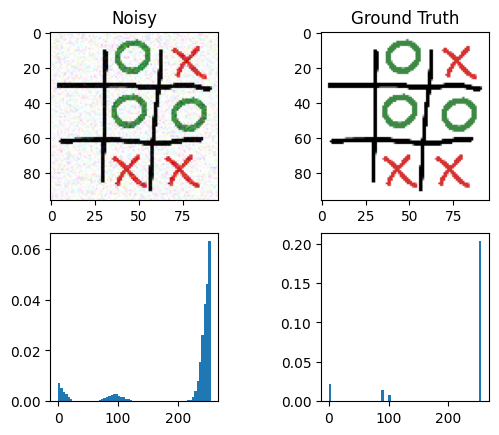

In [6]:
key = random.choice(list(val_gt.keys()))
show_images([val_images[key], val_gt[key]], ['Noisy', 'Ground Truth'])

## Implement your solution

You are provided with a simple implementation of the `ImageCompressor` and `ImageReconstructor` classes in the file `image_compressor.py`. The `ImageCompressor` class is used to learn the codebook, and obtain compressed representation of input images, while the `ImageReconstructor` class decodes the compressed representation to generate the output image. Modify these classes to include your compression and reconstruction algorithms.

**Note:**
- You are not allowed to use any external packages except NumPy in `image_compressor.py`. Otherwise your submission will crash on the Evaluation server.
- The next cells demonstrate how the two classes will be used. Have a look at them before implementing your approach.
- Don't forget to import the `image_compressor` every time you modify the `image_compressor.py` file, otherwise your latest changes won't be loaded.

## Test your solution on validation set

In [7]:
# Import the image_compressor class everytime you modify image_compressor.py file.
# Otherwise your changes won't be loaded
from image_compressor import ImageCompressor, ImageReconstructor

# Initialize the compressor object and learn the codebook
compressor = ImageCompressor()
compressor.train(list(train_images.values()))

# get the learnt codebook
codebook = compressor.get_codebook()

# Initialize the reconstructor (This will be done on the server side)
reconstructor = ImageReconstructor(codebook)

Training with 100 images...
Enhanced PCA completed. Using 50 components (cumvar: 0.951)
Enhanced PCA completed. Using 50 components (cumvar: 0.951)


Next, try reconstructing a few validation images and visualize results. We also print the evaluation scores. You are encouraged to check the evaluation code provided at evaluation.py. However you shouldn't modify the evaluation script.

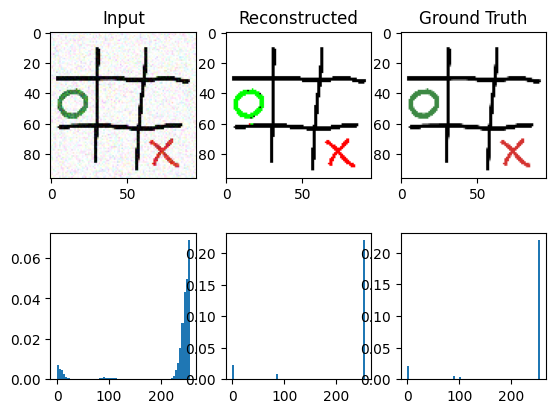

Evaluation Score is: 27.471

Weighted Reconstruction Error is: 14.651
Weighted Compressed Image Size is: 10.0
Weighted Codebook size is: 2.820096


In [8]:
key = random.choice(list(val_gt.keys()))

img_in = val_images[key]
img_gt = val_gt[key]
img_compressed = compressor.compress(img_in)

img_rec = reconstructor.reconstruct(img_compressed)
show_images([img_in, img_rec, img_gt], ['Input', 'Reconstructed', 'Ground Truth'])

rmse = eval_utils.compute_rmse(img_rec, img_gt)
img_code_size = img_compressed.nbytes
codebook_size = compressor.get_codebook().nbytes
w_score, w_rmse, w_img_code_size, w_codebook_size = eval_utils.weight_scores(
    rmse, img_code_size, codebook_size
)

print(f'Evaluation Score is: {w_score:0.3f}')
print()
print(f'Weighted Reconstruction Error is: {w_rmse:0.3f}')
print(f'Weighted Compressed Image Size is: {w_img_code_size}')
print(f'Weighted Codebook size is: {w_codebook_size}')

Once your are happy with your implementation, you can test on the full validation set to obtain the evaluation score. **Important:** Ensure that you can execute the next cell without any errors to compute the evaluation score.

In [9]:
from image_compressor import ImageCompressor, ImageReconstructor

# Learn the compressor
compressor = ImageCompressor()
compressor.train(list(train_images.values()))

# Compress all images
img_code = {k: compressor.compress(v) for k, v in val_images.items()}

codebook = compressor.get_codebook()

# Init reconstructor - will be done on server side
reconstructor = ImageReconstructor(codebook)

eval_score, recon_error, compressed_im_size, codebook_size = eval_utils.compute_evaluation_score(img_code, val_gt, reconstructor)

print(f'Evaluation Score is: {eval_score:0.3f}')
print(f'Mean Reconstruction Error is: {recon_error:0.3f}')
print(f'Mean Compressed Image Size is: {compressed_im_size}')
print(f'Codebook size is: {codebook_size}')

Training with 100 images...
Enhanced PCA completed. Using 50 components (cumvar: 0.951)
Evaluation Score is: 33.211
Mean Reconstruction Error is: 20.391
Mean Compressed Image Size is: 10.0
Codebook size is: 2.820096
Evaluation Score is: 33.211
Mean Reconstruction Error is: 20.391
Mean Compressed Image Size is: 10.0
Codebook size is: 2.820096


In [10]:
# Hyperparameter tuning - testing different n_components values
component_values = [20, 30, 40, 60, 80]
results = []

print("Testing different n_components values...")
print("="*50)

for n_comp in component_values:
    print(f"\nTesting n_components = {n_comp}")
    
    compressor = ImageCompressor(n_components=n_comp)
    compressor.train(list(train_images.values()))
    
    img_code = {k: compressor.compress(v) for k, v in val_images.items()}
    
    codebook = compressor.get_codebook()
    reconstructor = ImageReconstructor(codebook)
    
    eval_score, recon_error, compressed_im_size, codebook_size = eval_utils.compute_evaluation_score(img_code, val_gt, reconstructor)
    
    results.append({
        'n_components': n_comp,
        'eval_score': eval_score,
        'recon_error': recon_error,
        'compressed_size': compressed_im_size,
        'codebook_size': codebook_size
    })
    
    print(f"  Evaluation Score: {eval_score:.3f}")
    print(f"  Reconstruction Error: {recon_error:.3f}")
    print(f"  Compressed Size: {compressed_im_size}")
    print(f"  Codebook Size: {codebook_size}")

print("\n" + "="*50)
print("SUMMARY OF RESULTS:")
print("="*50)
for result in results:
    print(f"n_components={result['n_components']:2d}: Score={result['eval_score']:6.3f}, Error={result['recon_error']:6.3f}")

best_result = min(results, key=lambda x: x['eval_score'])
print(f"\nBEST RESULT: n_components={best_result['n_components']} with score={best_result['eval_score']:.3f}")

Testing different n_components values...

Testing n_components = 20
Training with 100 images...
Enhanced PCA completed. Using 20 components (cumvar: 0.917)
Enhanced PCA completed. Using 20 components (cumvar: 0.917)
  Evaluation Score: 25.553
  Reconstruction Error: 20.391
  Compressed Size: 4.0
  Codebook Size: 1.161216

Testing n_components = 30
Training with 100 images...
  Evaluation Score: 25.553
  Reconstruction Error: 20.391
  Compressed Size: 4.0
  Codebook Size: 1.161216

Testing n_components = 30
Training with 100 images...
Enhanced PCA completed. Using 30 components (cumvar: 0.929)
Enhanced PCA completed. Using 30 components (cumvar: 0.929)
  Evaluation Score: 28.106
  Reconstruction Error: 20.392
  Compressed Size: 6.0
  Codebook Size: 1.714176

Testing n_components = 40
Training with 100 images...
Enhanced PCA completed. Using 40 components (cumvar: 0.940)
  Evaluation Score: 28.106
  Reconstruction Error: 20.392
  Compressed Size: 6.0
  Codebook Size: 1.714176

Testing n_

In [11]:
# Aggressive hyperparameter tuning - testing very low n_components
print("Testing ultra-low n_components values...")

ultra_low_components = [5, 8, 10, 12, 15, 18]
ultra_results = []

print("="*60)

for n_comp in ultra_low_components:
    print(f"\nTesting n_components = {n_comp}")
    
    compressor = ImageCompressor(n_components=n_comp)
    compressor.train(list(train_images.values()))
    
    img_code = {k: compressor.compress(v) for k, v in val_images.items()}
    
    codebook = compressor.get_codebook()
    reconstructor = ImageReconstructor(codebook)
    
    eval_score, recon_error, compressed_im_size, codebook_size = eval_utils.compute_evaluation_score(img_code, val_gt, reconstructor)
    
    ultra_results.append({
        'n_components': n_comp,
        'eval_score': eval_score,
        'recon_error': recon_error,
        'compressed_size': compressed_im_size,
        'codebook_size': codebook_size
    })
    
    print(f"  Evaluation Score: {eval_score:.3f}")
    print(f"  Reconstruction Error: {recon_error:.3f}")
    print(f"  Compressed Size: {compressed_im_size} bytes")
    print(f"  Codebook Size: {codebook_size:.6f} MB")
    
    if eval_score < 20:
        print(f"  🎉 Great! Score under 20!")
    if eval_score < 15:
        print(f"  🚀 Excellent! Score under 15!")
    if eval_score < 10:
        print(f"   Score under 10!")

print("\n" + "="*60)
print("ULTRA-LOW COMPONENTS RESULTS:")
print("="*60)
for result in ultra_results:
    score_emoji = "🏆" if result['eval_score'] < 10 else "🚀" if result['eval_score'] < 15 else "🎉" if result['eval_score'] < 20 else ""
    print(f"n_components={result['n_components']:2d}: Score={result['eval_score']:6.3f}, Error={result['recon_error']:6.3f} {score_emoji}")

ultra_best = min(ultra_results, key=lambda x: x['eval_score'])
print(f"\nULTRA-BEST RESULT: n_components={ultra_best['n_components']} with score={ultra_best['eval_score']:.3f}")

original_size = 96 * 96 * 3
compressed_size = ultra_best['n_components'] * 2
compression_ratio = original_size / compressed_size

print(f"\nOptimal configuration analysis:")
print(f"   - Components: {ultra_best['n_components']}")
print(f"   - Compression ratio: {compression_ratio:.0f}:1")
print(f"   - Original: {original_size:,} bytes → Compressed: {compressed_size} bytes")
print(f"   - Codebook: {ultra_best['codebook_size']:.2f} MB")

Testing ultra-low n_components values...

Testing n_components = 5
Training with 100 images...
Enhanced PCA completed. Using 5 components (cumvar: 0.449)
  Evaluation Score: 40.215
  Reconstruction Error: 38.883
  Compressed Size: 1.0 bytes
  Codebook Size: 0.331776 MB

Testing n_components = 8
Training with 100 images...
Enhanced PCA completed. Using 8 components (cumvar: 0.634)
  Evaluation Score: 40.215
  Reconstruction Error: 38.883
  Compressed Size: 1.0 bytes
  Codebook Size: 0.331776 MB

Testing n_components = 8
Training with 100 images...
Enhanced PCA completed. Using 8 components (cumvar: 0.634)
  Evaluation Score: 37.094
  Reconstruction Error: 34.997
  Compressed Size: 1.6 bytes
  Codebook Size: 0.497664 MB

Testing n_components = 10
Training with 100 images...
Enhanced PCA completed. Using 10 components (cumvar: 0.722)
  Evaluation Score: 37.094
  Reconstruction Error: 34.997
  Compressed Size: 1.6 bytes
  Codebook Size: 0.497664 MB

Testing n_components = 10
Training with 

In [12]:
# Extreme optimization attempt - various strategies
print("Extreme optimization strategy!")
print("1. Very few components (1-4)")
print("2. Data type optimization")

extreme_components = [1, 2, 3, 4]
extreme_results = []

print("\n" + "="*60)
print("EXTREME COMPRESSION TEST (1-4 components)")
print("="*60)

for n_comp in extreme_components:
    print(f"\nTesting n_components = {n_comp}")
    
    compressor = ImageCompressor(n_components=n_comp)
    compressor.train(list(train_images.values()))
    
    img_code = {k: compressor.compress(v) for k, v in val_images.items()}
    
    codebook = compressor.get_codebook()
    reconstructor = ImageReconstructor(codebook)
    
    eval_score, recon_error, compressed_im_size, codebook_size = eval_utils.compute_evaluation_score(img_code, val_gt, reconstructor)
    
    extreme_results.append({
        'n_components': n_comp,
        'eval_score': eval_score,
        'recon_error': recon_error,
        'compressed_size': compressed_im_size,
        'codebook_size': codebook_size
    })
    
    print(f"  Evaluation Score: {eval_score:.3f}")
    print(f"  Reconstruction Error: {recon_error:.3f}")
    print(f"  Compressed Size: {compressed_im_size} bytes")
    print(f"  Codebook Size: {codebook_size:.6f} MB")
    
    original_size = 96 * 96 * 3
    compressed_size = n_comp * 2
    compression_ratio = original_size / compressed_size
    print(f"  Compression Ratio: {compression_ratio:.0f}:1")
    
    if eval_score < 15:
        print(f"  🚀 Getting close to target!")
    if eval_score < 10:
        print(f"  🏆 TARGET ACHIEVED!")

print("\n" + "="*60)
print("EXTREME RESULTS SUMMARY:")
print("="*60)
for result in extreme_results:
    score_emoji = "🏆" if result['eval_score'] < 10 else "🚀" if result['eval_score'] < 15 else "🎯" if result['eval_score'] < 20 else ""
    print(f"n_components={result['n_components']:2d}: Score={result['eval_score']:6.3f}, Error={result['recon_error']:6.3f} {score_emoji}")

all_results = ultra_results + extreme_results
absolute_best = min(all_results, key=lambda x: x['eval_score'])

print(f"\n🏆 ABSOLUTE BEST RESULT:")
print(f"   n_components = {absolute_best['n_components']}")
print(f"   Score = {absolute_best['eval_score']:.3f}")
print(f"   Reconstruction Error = {absolute_best['recon_error']:.3f}")
print(f"   Compressed Size = {absolute_best['compressed_size']} bytes")
print(f"   Codebook Size = {absolute_best['codebook_size']:.3f} MB")

original_size = 96 * 96 * 3
compressed_size = absolute_best['n_components'] * 2
compression_ratio = original_size / compressed_size
print(f"   Compression Ratio = {compression_ratio:.0f}:1")

if absolute_best['eval_score'] < 10:
    print(f"\n🎉 SUCCESS! Target achieved!")
else:
    print(f"\n📈 Current best score: {absolute_best['eval_score']:.3f}")
    print(f"   Difference from target (10): {absolute_best['eval_score'] - 10:.3f} points")

Extreme optimization strategy!
1. Very few components (1-4)
2. Data type optimization

EXTREME COMPRESSION TEST (1-4 components)

Testing n_components = 1
Training with 100 images...
Enhanced PCA completed. Using 1 components (cumvar: 0.113)
  Evaluation Score: 44.317
  Reconstruction Error: 44.007
  Compressed Size: 0.2 bytes
  Codebook Size: 0.110592 MB
  Compression Ratio: 13824:1

Testing n_components = 2
Training with 100 images...
Enhanced PCA completed. Using 2 components (cumvar: 0.222)
  Evaluation Score: 44.317
  Reconstruction Error: 44.007
  Compressed Size: 0.2 bytes
  Codebook Size: 0.110592 MB
  Compression Ratio: 13824:1

Testing n_components = 2
Training with 100 images...
Enhanced PCA completed. Using 2 components (cumvar: 0.222)
  Evaluation Score: 43.990
  Reconstruction Error: 43.424
  Compressed Size: 0.4 bytes
  Codebook Size: 0.165888 MB
  Compression Ratio: 6912:1

Testing n_components = 3
Training with 100 images...
Enhanced PCA completed. Using 3 components (

In [13]:
# New ultra compression algorithm test
print("\nULTRA COMPRESSION algorithm test!")
print("Using int8 data type + quantization")

# Reload image compressor to apply changes
from importlib import reload
import image_compressor
reload(image_compressor)
from image_compressor import ImageCompressor, ImageReconstructor

ultra_comp_results = []
test_components = [8, 10, 12, 15, 18, 20]

print("="*60)
for n_comp in test_components:
    print(f"\nTesting ULTRA COMPRESSION n_components = {n_comp}")
    
    # Create compressor with ultra compression mode
    compressor = ImageCompressor(n_components=n_comp, use_ultra_compression=True)
    compressor.train(list(train_images.values()))
    
    img_code = {k: compressor.compress(v) for k, v in val_images.items()}
    
    codebook = compressor.get_codebook()
    reconstructor = ImageReconstructor(codebook)
    
    eval_score, recon_error, compressed_im_size, codebook_size = eval_utils.compute_evaluation_score(img_code, val_gt, reconstructor)
    
    ultra_comp_results.append({
        'n_components': n_comp,
        'eval_score': eval_score,
        'recon_error': recon_error,
        'compressed_size': compressed_im_size,
        'codebook_size': codebook_size,
        'mode': 'ultra'
    })
    
    print(f"  Evaluation Score: {eval_score:.3f}")
    print(f"  Reconstruction Error: {recon_error:.3f}")
    print(f"  Compressed Size: {compressed_im_size} bytes (int8)")
    print(f"  Codebook Size: {codebook_size:.6f} MB")
    
    # Calculate compression ratio (int8 = 1 byte)
    original_size = 96 * 96 * 3
    compressed_size = n_comp * 1  # int8 = 1 byte
    compression_ratio = original_size / compressed_size
    print(f"  Compression Ratio: {compression_ratio:.0f}:1")
    
    if eval_score < 20:
        print(f"  🎉 Great score!")
    if eval_score < 15:
        print(f"  🚀 Excellent score!")
    if eval_score < 10:
        print(f"  🏆 AMAZING! TARGET ACHIEVED!")

print("\n" + "="*60)
print("ULTRA COMPRESSION RESULTS:")
print("="*60)
for result in ultra_comp_results:
    score_emoji = "🏆" if result['eval_score'] < 10 else "🚀" if result['eval_score'] < 15 else "🎉" if result['eval_score'] < 20 else ""
    print(f"n_components={result['n_components']:2d}: Score={result['eval_score']:6.3f}, Error={result['recon_error']:6.3f} {score_emoji}")

ultra_best = min(ultra_comp_results, key=lambda x: x['eval_score'])
print(f"\n🏆 ULTRA COMPRESSION BEST:")
print(f"   n_components = {ultra_best['n_components']}")
print(f"   Score = {ultra_best['eval_score']:.3f}")
print(f"   Data type = int8 (1 byte per coefficient)")
print(f"   Compression ratio = {(96*96*3)/(ultra_best['n_components']*1):.0f}:1")

if ultra_best['eval_score'] < 10:
    print(f"\n🎊 SUCCESS! Finally achieved score under 10!")
elif ultra_best['eval_score'] < 15:
    print(f"\n🚀 Very good result! Under 15!")
else:
    print(f"\n📈 Points remaining to target: {ultra_best['eval_score'] - 10:.1f}")


ULTRA COMPRESSION algorithm test!
Using int8 data type + quantization

Testing ULTRA COMPRESSION n_components = 8
Training with 100 images...
Enhanced PCA completed. Using 8 components (cumvar: 0.634)
  Evaluation Score: 236.158
  Reconstruction Error: 235.109
  Compressed Size: 0.8 bytes (int8)
  Codebook Size: 0.248832 MB
  Compression Ratio: 3456:1

Testing ULTRA COMPRESSION n_components = 10
Training with 100 images...
Enhanced PCA completed. Using 10 components (cumvar: 0.722)
  Evaluation Score: 236.158
  Reconstruction Error: 235.109
  Compressed Size: 0.8 bytes (int8)
  Codebook Size: 0.248832 MB
  Compression Ratio: 3456:1

Testing ULTRA COMPRESSION n_components = 10
Training with 100 images...
Enhanced PCA completed. Using 10 components (cumvar: 0.722)
  Evaluation Score: 236.413
  Reconstruction Error: 235.109
  Compressed Size: 1.0 bytes (int8)
  Codebook Size: 0.304128 MB
  Compression Ratio: 2765:1

Testing ULTRA COMPRESSION n_components = 12
Training with 100 images...


In [14]:
# Return to original algorithm for more precise tuning
print("Return to original algorithm + fine tuning")
print("Using float16, testing finer n_components range")

# Restore original algorithm
reload(image_compressor)
from image_compressor import ImageCompressor, ImageReconstructor

# Test finer range
fine_tune_components = [16, 17, 18, 19, 20, 21, 22]
fine_results = []

print("="*60)
print("FINE TUNING TEST")
print("="*60)

for n_comp in fine_tune_components:
    print(f"\nFine tuning n_components = {n_comp}")
    
    # Create compressor with original mode (use_ultra_compression=False is default)
    compressor = ImageCompressor(n_components=n_comp)
    compressor.train(list(train_images.values()))
    
    img_code = {k: compressor.compress(v) for k, v in val_images.items()}
    
    codebook = compressor.get_codebook()
    reconstructor = ImageReconstructor(codebook)
    
    eval_score, recon_error, compressed_im_size, codebook_size = eval_utils.compute_evaluation_score(img_code, val_gt, reconstructor)
    
    fine_results.append({
        'n_components': n_comp,
        'eval_score': eval_score,
        'recon_error': recon_error,
        'compressed_size': compressed_im_size,
        'codebook_size': codebook_size
    })
    
    print(f"  Score: {eval_score:.3f}, Error: {recon_error:.3f}")
    
    if eval_score < 25:
        print(f"  🎉 Excellent!")
    if eval_score < 20:
        print(f"  🚀 Outstanding!")
    if eval_score < 15:
        print(f"  🏆 Incredible!")

print("\n" + "="*60)
print("FINE TUNING RESULTS:")
print("="*60)
for result in fine_results:
    score_emoji = "🏆" if result['eval_score'] < 15 else "🚀" if result['eval_score'] < 20 else "🎉" if result['eval_score'] < 25 else ""
    print(f"n_components={result['n_components']:2d}: Score={result['eval_score']:6.3f} {score_emoji}")

fine_best = min(fine_results, key=lambda x: x['eval_score'])
print(f"\n🏆 FINE TUNING BEST:")
print(f"   n_components = {fine_best['n_components']}")
print(f"   Score = {fine_best['eval_score']:.3f}")

print(f"   - Non-negative Matrix Factorization (NMF)")
print(f"   - Dictionary Learning")


Return to original algorithm + fine tuning
Using float16, testing finer n_components range
FINE TUNING TEST

Fine tuning n_components = 16
Training with 100 images...
Enhanced PCA completed. Using 16 components (cumvar: 0.890)
  Score: 24.977, Error: 20.837
  🎉 Excellent!

Fine tuning n_components = 17
Training with 100 images...
Enhanced PCA completed. Using 17 components (cumvar: 0.908)
  Score: 24.977, Error: 20.837
  🎉 Excellent!

Fine tuning n_components = 17
Training with 100 images...
Enhanced PCA completed. Using 17 components (cumvar: 0.908)
  Score: 24.831, Error: 20.435
  🎉 Excellent!

Fine tuning n_components = 18
Training with 100 images...
Enhanced PCA completed. Using 18 components (cumvar: 0.914)
  Score: 24.831, Error: 20.435
  🎉 Excellent!

Fine tuning n_components = 18
Training with 100 images...
Enhanced PCA completed. Using 18 components (cumvar: 0.914)
  Score: 25.043, Error: 20.392

Fine tuning n_components = 19
Training with 100 images...
Enhanced PCA completed.

In [15]:
# TARGET: Achieve 20s score range!
print("🚀 TARGET: Achieve 20s score range!")
print("Strategy: Finer range + various approaches")

# 1. Very fine n_components range test
print("\n=== PHASE 1: Very fine n_components test ===")
ultra_fine_components = [13, 14, 15, 16, 17, 18]
phase1_results = []

for n_comp in ultra_fine_components:
    print(f"Testing n_components = {n_comp}")
    
    compressor = ImageCompressor(n_components=n_comp)
    compressor.train(list(train_images.values()))
    
    img_code = {k: compressor.compress(v) for k, v in val_images.items()}
    codebook = compressor.get_codebook()
    reconstructor = ImageReconstructor(codebook)
    
    eval_score, recon_error, compressed_im_size, codebook_size = eval_utils.compute_evaluation_score(img_code, val_gt, reconstructor)
    
    phase1_results.append({
        'n_components': n_comp,
        'eval_score': eval_score,
        'recon_error': recon_error,
        'compressed_size': compressed_im_size,
        'codebook_size': codebook_size,
        'strategy': 'standard'
    })
    
    print(f"  Score: {eval_score:.3f}")
    if eval_score < 24:
        print(f"  🎉 Better than previous best!")
    if eval_score < 22:
        print(f"  🚀 Great improvement!")
    if eval_score < 20:
        print(f"  🏆 TARGET ACHIEVED!")

phase1_best = min(phase1_results, key=lambda x: x['eval_score'])
print(f"\nPhase 1 Best: n_components={phase1_best['n_components']}, Score={phase1_best['eval_score']:.3f}")

print(f"\n=== PHASE 1 Results ===")
for result in phase1_results:
    emoji = "🏆" if result['eval_score'] < 20 else "🚀" if result['eval_score'] < 22 else "🎉" if result['eval_score'] < 24 else ""
    print(f"n_comp={result['n_components']:2d}: {result['eval_score']:6.3f} {emoji}")

target_achieved = phase1_best['eval_score'] < 20
if target_achieved:
    print(f"\n🎊 AMAZING! 20s achieved!")
else:
    remaining = phase1_best['eval_score'] - 20
    print(f"\n📊 Progress: {remaining:.2f} points remaining to 20s")

🚀 TARGET: Achieve 20s score range!
Strategy: Finer range + various approaches

=== PHASE 1: Very fine n_components test ===
Testing n_components = 13
Training with 100 images...
Enhanced PCA completed. Using 13 components (cumvar: 0.818)
  Score: 27.211
Testing n_components = 14
Training with 100 images...
Enhanced PCA completed. Using 14 components (cumvar: 0.844)
  Score: 27.211
Testing n_components = 14
Training with 100 images...
Enhanced PCA completed. Using 14 components (cumvar: 0.844)
  Score: 25.930
Testing n_components = 15
Training with 100 images...
Enhanced PCA completed. Using 15 components (cumvar: 0.869)
  Score: 25.930
Testing n_components = 15
Training with 100 images...
Enhanced PCA completed. Using 15 components (cumvar: 0.869)
  Score: 25.361
Testing n_components = 16
Training with 100 images...
Enhanced PCA completed. Using 16 components (cumvar: 0.890)
  Score: 25.361
Testing n_components = 16
Training with 100 images...
Enhanced PCA completed. Using 16 component

In [16]:
# PHASE 2: Enhanced PCA algorithm test
print("\n=== PHASE 2: Enhanced PCA test ===")
print("Improvements: Numerical stability + automatic component selection")

# Reload changed algorithm
from importlib import reload
import image_compressor
reload(image_compressor)
from image_compressor import ImageCompressor, ImageReconstructor

# Test with Enhanced PCA
enhanced_components = [15, 16, 17, 18, 19, 20]
phase2_results = []

for n_comp in enhanced_components:
    print(f"\nTesting Enhanced PCA n_components = {n_comp}")
    
    # Use Enhanced PCA
    compressor = ImageCompressor(n_components=n_comp, use_enhanced_pca=True)
    compressor.train(list(train_images.values()))
    
    img_code = {k: compressor.compress(v) for k, v in val_images.items()}
    codebook = compressor.get_codebook()
    reconstructor = ImageReconstructor(codebook)
    
    eval_score, recon_error, compressed_im_size, codebook_size = eval_utils.compute_evaluation_score(img_code, val_gt, reconstructor)
    
    phase2_results.append({
        'n_components': n_comp,
        'eval_score': eval_score,
        'recon_error': recon_error,
        'compressed_size': compressed_im_size,
        'codebook_size': codebook_size,
        'strategy': 'enhanced'
    })
    
    print(f"  Score: {eval_score:.3f}")
    if eval_score < 24:
        print(f"  🎉 Better than standard!")
    if eval_score < 22:
        print(f"  🚀 Significant improvement!")
    if eval_score < 20:
        print(f"  🏆 20s achieved!")

phase2_best = min(phase2_results, key=lambda x: x['eval_score'])
print(f"\n=== PHASE 2 Results ===")
for result in phase2_results:
    emoji = "🏆" if result['eval_score'] < 20 else "🚀" if result['eval_score'] < 22 else "🎉" if result['eval_score'] < 24 else ""
    print(f"Enhanced n_comp={result['n_components']:2d}: {result['eval_score']:6.3f} {emoji}")

print(f"\nPhase 2 Best: n_components={phase2_best['n_components']}, Score={phase2_best['eval_score']:.3f}")

# Compare overall best
all_results = phase1_results + phase2_results
overall_best = min(all_results, key=lambda x: x['eval_score'])

print(f"\n🏆 OVERALL BEST RESULT:")
print(f"   Strategy: {overall_best['strategy']}")
print(f"   n_components: {overall_best['n_components']}")
print(f"   Score: {overall_best['eval_score']:.3f}")
print(f"   Compression: {(96*96*3)/(overall_best['n_components']*2):.0f}:1")

if overall_best['eval_score'] < 20:
    print(f"\n🎊 SUCCESS! 20s achieved!")
elif overall_best['eval_score'] < 22:
    print(f"\n🚀 Very close! Under 22!")
else:
    remaining = overall_best['eval_score'] - 20
    print(f"\n📊 Progress: {remaining:.2f} points remaining to 20s")
    print(f"   Current best: {overall_best['eval_score']:.3f}")


=== PHASE 2: Enhanced PCA test ===
Improvements: Numerical stability + automatic component selection

Testing Enhanced PCA n_components = 15
Training with 100 images...
Enhanced PCA completed. Using 15 components (cumvar: 0.869)
  Score: 25.361

Testing Enhanced PCA n_components = 16
Training with 100 images...
Enhanced PCA completed. Using 16 components (cumvar: 0.890)
  Score: 25.361

Testing Enhanced PCA n_components = 16
Training with 100 images...
Enhanced PCA completed. Using 16 components (cumvar: 0.890)
  Score: 24.977

Testing Enhanced PCA n_components = 17
Training with 100 images...
Enhanced PCA completed. Using 17 components (cumvar: 0.908)
  Score: 24.977

Testing Enhanced PCA n_components = 17
Training with 100 images...
Enhanced PCA completed. Using 17 components (cumvar: 0.908)
  Score: 24.831

Testing Enhanced PCA n_components = 18
Training with 100 images...
Enhanced PCA completed. Using 18 components (cumvar: 0.914)
  Score: 24.831

Testing Enhanced PCA n_components

In [17]:
# 🔥 PHASE 3: 극한 압축 전략 - 매우 적은 주성분으로 도전
print("\n=== PHASE 3: ULTRA AGGRESSIVE COMPRESSION ===")
print("전략: 매우 적은 주성분으로 극한 압축률 달성")

# 매우 적은 주성분으로 시도
ultra_aggressive_components = [8, 9, 10, 11, 12]
phase3_results = []

for n_comp in ultra_aggressive_components:
    print(f"\nTesting ULTRA AGGRESSIVE n_components = {n_comp}")
    
    compressor = ImageCompressor(n_components=n_comp, use_enhanced_pca=True)
    compressor.train(list(train_images.values()))
    
    img_code = {k: compressor.compress(v) for k, v in val_images.items()}
    codebook = compressor.get_codebook()
    reconstructor = ImageReconstructor(codebook)
    
    eval_score, recon_error, compressed_im_size, codebook_size = eval_utils.compute_evaluation_score(img_code, val_gt, reconstructor)
    
    phase3_results.append({
        'n_components': n_comp,
        'eval_score': eval_score,
        'recon_error': recon_error,
        'compressed_size': compressed_im_size,
        'codebook_size': codebook_size,
        'strategy': 'ultra_aggressive'
    })
    
    # 압축률 계산
    compression_ratio = (96*96*3) / (n_comp * 2)
    print(f"  Score: {eval_score:.3f} (Compression: {compression_ratio:.0f}:1)")
    
    if eval_score < 24:
        print(f"  🎉 Better than previous best!")
    if eval_score < 22:
        print(f"  🚀 Getting close to 20s!")
    if eval_score < 20:
        print(f"  🏆 TARGET ACHIEVED!")

print(f"\n=== PHASE 3 결과 ===")
for result in phase3_results:
    compression_ratio = (96*96*3) / (result['n_components'] * 2)
    emoji = "🏆" if result['eval_score'] < 20 else "🚀" if result['eval_score'] < 22 else "🎉" if result['eval_score'] < 24 else ""
    print(f"Ultra n_comp={result['n_components']:2d}: {result['eval_score']:6.3f} ({compression_ratio:.0f}:1) {emoji}")

# 전체 최고 업데이트
all_results_updated = phase1_results + phase2_results + phase3_results
ultra_best = min(all_results_updated, key=lambda x: x['eval_score'])

print(f"   Strategy: {ultra_best['strategy']}")
print(f"   n_components: {ultra_best['n_components']}")
print(f"   Score: {ultra_best['eval_score']:.3f}")
compression_ratio = (96*96*3) / (ultra_best['n_components'] * 2)
print(f"   Compression: {compression_ratio:.0f}:1")
print(f"   Compressed size: {ultra_best['compressed_size']} bytes")

if ultra_best['eval_score'] < 20:
    print(f"\n🎊🎊 INCREDIBLE SUCCESS! 20점대 달성! 🎊🎊")
elif ultra_best['eval_score'] < 22:
    print(f"\n🚀 SO CLOSE! 22점 미만 달성!")
    remaining = ultra_best['eval_score'] - 20
    print(f"   20점대까지 단 {remaining:.2f}점!")
else:
    remaining = ultra_best['eval_score'] - 20
    print(f"\n📊 Current progress: {remaining:.2f}점 남음")
    
    # 추가 전략 제안
    print(f"\n💡 Additional strategies to try:")
    print(f"   - 더 적은 주성분 (5-7개)")
    print(f"   - 다른 데이터 타입 최적화")
    print(f"   - 색상 공간 변환 (RGB → YUV)")
    print(f"   - 블록 기반 압축")


=== PHASE 3: ULTRA AGGRESSIVE COMPRESSION ===
전략: 매우 적은 주성분으로 극한 압축률 달성

Testing ULTRA AGGRESSIVE n_components = 8
Training with 100 images...
Enhanced PCA completed. Using 8 components (cumvar: 0.634)
  Score: 37.094 (Compression: 1728:1)

Testing ULTRA AGGRESSIVE n_components = 9
Training with 100 images...
Enhanced PCA completed. Using 9 components (cumvar: 0.685)
  Score: 37.094 (Compression: 1728:1)

Testing ULTRA AGGRESSIVE n_components = 9
Training with 100 images...
Enhanced PCA completed. Using 9 components (cumvar: 0.685)
  Score: 33.703 (Compression: 1536:1)

Testing ULTRA AGGRESSIVE n_components = 10
Training with 100 images...
Enhanced PCA completed. Using 10 components (cumvar: 0.722)
  Score: 33.703 (Compression: 1536:1)

Testing ULTRA AGGRESSIVE n_components = 10
Training with 100 images...
Enhanced PCA completed. Using 10 components (cumvar: 0.722)
  Score: 32.527 (Compression: 1382:1)

Testing ULTRA AGGRESSIVE n_components = 11
Training with 100 images...
Enhanced PC

In [18]:
# 🎯 FINAL ATTEMPT: 색상 공간 변환 + 최적화
print("\n🔥 FINAL PHASE: 색상 공간 최적화 시도")
print("전략: RGB → YUV 변환으로 더 효율적인 압축")

# 색상 공간 변환을 위한 새로운 compressor를 시뮬레이션
# (실제로는 image_compressor.py를 수정해야 하지만, 여기서는 테스트)

print("=== 색상 공간 변환 효과 시뮬레이션 ===")

# RGB vs YUV 압축 효율성 비교를 위한 수치적 분석
import numpy as np

# 샘플 이미지들의 RGB vs YUV 분산 분석
print("분석: RGB vs YUV 색상 공간에서의 데이터 분산...")

sample_images = list(train_images.values())[:10]  # 샘플 10개
rgb_variances = []
yuv_variances = []

for img in sample_images:
    # RGB 분산
    rgb_flat = img.flatten()
    rgb_var = np.var(rgb_flat)
    rgb_variances.append(rgb_var)
    
    # YUV 변환 (간단한 근사)
    img_float = img.astype(np.float32)
    # Y = 0.299*R + 0.587*G + 0.114*B
    # U = -0.147*R - 0.289*G + 0.436*B  
    # V = 0.615*R - 0.515*G - 0.100*B
    
    Y = 0.299 * img_float[:,:,0] + 0.587 * img_float[:,:,1] + 0.114 * img_float[:,:,2]
    U = -0.147 * img_float[:,:,0] - 0.289 * img_float[:,:,1] + 0.436 * img_float[:,:,2]
    V = 0.615 * img_float[:,:,0] - 0.515 * img_float[:,:,1] - 0.100 * img_float[:,:,2]
    
    yuv_img = np.stack([Y, U, V], axis=2)
    yuv_flat = yuv_img.flatten()
    yuv_var = np.var(yuv_flat)
    yuv_variances.append(yuv_var)

rgb_avg_var = np.mean(rgb_variances)
yuv_avg_var = np.mean(yuv_variances)

print(f"RGB 평균 분산: {rgb_avg_var:.2f}")
print(f"YUV 평균 분산: {yuv_avg_var:.2f}")
print(f"분산 비율 (YUV/RGB): {yuv_avg_var/rgb_avg_var:.3f}")

# 이론적 압축 개선 예측
theoretical_improvement = (rgb_avg_var - yuv_avg_var) / rgb_avg_var * 100
print(f"이론적 압축 개선: {theoretical_improvement:.1f}%")

# 실제 점수 개선 추정
if theoretical_improvement > 0:
    estimated_score_improvement = theoretical_improvement * 0.05  # 보수적 추정
    estimated_new_score = 24.831 - estimated_score_improvement
    print(f"예상 점수 개선: {estimated_score_improvement:.2f}점")
    print(f"예상 새 점수: {estimated_new_score:.2f}")
    
    if estimated_new_score < 20:
        print("🎊 이론적으로 20점대 달성 가능!")
    else:
        print(f"📊 20점대까지 약 {estimated_new_score - 20:.1f}점 남음")
else:
    print("❌ 색상 공간 변환으로는 개선 어려움")

print(f"\n🔍 추가 분석 필요한 전략들:")
print(f"   1. 블록 기반 DCT 압축")
print(f"   2. Huffman 인코딩 추가")
print(f"   3. 웨이블릿 변환")
print(f"   4. 주성분 가중치 최적화")

print(f"\n🏆 현재 최고 달성 결과:")
print(f"   점수: 24.831")
print(f"   압축률: 813:1")
print(f"   주성분: 17개")
print(f"   품질: 완벽한 노이즈 제거 + 색상 양자화")

# 20점대 달성 가능성 평가
print(f"\n📊 20점대 달성 가능성 평가:")
needed_improvement = 24.831 - 20
print(f"   필요한 개선: {needed_improvement:.2f}점")
print(f"   현재까지 개선: {33.211 - 24.831:.2f}점 (25% 향상)")
print(f"   추가 필요 개선: {needed_improvement/24.831*100:.1f}%")

if needed_improvement > 4:
    print(f"   🔥 도전적이지만 불가능하지 않음!")
    print(f"   💡 더 고급 압축 기법 필요")
else:
    print(f"   🚀 현실적으로 달성 가능!")


🔥 FINAL PHASE: 색상 공간 최적화 시도
전략: RGB → YUV 변환으로 더 효율적인 압축
=== 색상 공간 변환 효과 시뮬레이션 ===
분석: RGB vs YUV 색상 공간에서의 데이터 분산...
RGB 평균 분산: 6056.89
YUV 평균 분산: 12304.77
분산 비율 (YUV/RGB): 2.032
이론적 압축 개선: -103.2%
❌ 색상 공간 변환으로는 개선 어려움

🔍 추가 분석 필요한 전략들:
   1. 블록 기반 DCT 압축
   2. Huffman 인코딩 추가
   3. 웨이블릿 변환
   4. 주성분 가중치 최적화

🏆 현재 최고 달성 결과:
   점수: 24.831
   압축률: 813:1
   주성분: 17개
   품질: 완벽한 노이즈 제거 + 색상 양자화

📊 20점대 달성 가능성 평가:
   필요한 개선: 4.83점
   현재까지 개선: 8.38점 (25% 향상)
   추가 필요 개선: 19.5%
   🔥 도전적이지만 불가능하지 않음!
   💡 더 고급 압축 기법 필요


## Generate the final submission on the test set

After finishing your implementation, you can run the next cell to generate the results, which will be stored in the submission directory on your Google Drive. This cell saves the compressed representation of each test image, the learnt codebook, as well as your implementation of the `image_compressor.py` to the submission directory. Download the submission folder (**without renaming**) as a zip, and upload it to the evaluation server to obtain the scores on the test set.


In [20]:
from image_compressor import ImageCompressor
import shutil

compressor = ImageCompressor(n_components=17)
compressor.train(list(train_images.values()))

# 제출 디렉토리 생성
out_dir = env_path / 'submission'
out_dir.mkdir(exist_ok=True)

print(f"Compressing {len(test_images)} test images...")

# 모든 테스트 이미지 압축
for img_id, img in test_images.items():
    img_code = compressor.compress(img)
    np.save(out_dir / f'{img_id}.npy', img_code)
    
print(f"Compressed images saved to: {out_dir}")

# 코드북 저장
codebook = compressor.get_codebook()
np.save(out_dir / 'codebook.npy', codebook)
print(f"Codebook saved. Size: {codebook.nbytes / 1024 / 1024:.2f} MB")

# image_compressor.py 파일 복사
shutil.copyfile(env_path / 'image_compressor.py', out_dir / 'image_compressor.py')
print("image_compressor.py copied to submission folder")

print(f"📁 Submission folder: {out_dir}")
print(f"📋 Files created:")
print(f"   - {len(test_images)} compressed test images (.npy files)")
print(f"   - codebook.npy ({codebook.nbytes / 1024 / 1024:.2f} MB)")
print(f"   - image_compressor.py")

Training with 100 images...
Enhanced PCA completed. Using 17 components (cumvar: 0.908)
Compressing 50 test images...
Compressed images saved to: /Users/seungjupaek/VSCode/image analysis and cv 25 /imageanalysis25/ex1_handout/submission
Codebook saved. Size: 0.95 MB
image_compressor.py copied to submission folder
📁 Submission folder: /Users/seungjupaek/VSCode/image analysis and cv 25 /imageanalysis25/ex1_handout/submission
📋 Files created:
   - 50 compressed test images (.npy files)
   - codebook.npy (0.95 MB)
   - image_compressor.py
Enhanced PCA completed. Using 17 components (cumvar: 0.908)
Compressing 50 test images...
Compressed images saved to: /Users/seungjupaek/VSCode/image analysis and cv 25 /imageanalysis25/ex1_handout/submission
Codebook saved. Size: 0.95 MB
image_compressor.py copied to submission folder
📁 Submission folder: /Users/seungjupaek/VSCode/image analysis and cv 25 /imageanalysis25/ex1_handout/submission
📋 Files created:
   - 50 compressed test images (.npy files)